# Convert Spectrum to Color

The python code for color converstion are from the following study:
https://scipython.com/blog/converting-a-spectrum-to-a-colour/

## Load modules

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.insert(0, '../protected')
from colour_system import *
cs = cs_hdtv
#the code are provided from https://scipython.com/blog/converting-a-spectrum-to-a-colour/

In [5]:
#code from https://scipython.com/blog/converting-a-spectrum-to-a-colour/
#colour_system.py
import numpy as np

lam = np.arange(380., 781., 5)

def xyz_from_xy(x, y):
    """Return the vector (x, y, 1-x-y)."""
    return np.array((x, y, 1-x-y))

class ColourSystem:
    """A class representing a colour system.

    A colour system defined by the CIE x, y and z=1-x-y coordinates of
    its three primary illuminants and its "white point".

    TODO: Implement gamma correction

    """

    # The CIE colour matching function for 380 - 780 nm in 5 nm intervals
    cmf = np.loadtxt('../data/cie-cmf.txt', usecols=(1,2,3))

    def __init__(self, red, green, blue, white):
        """Initialise the ColourSystem object.

        Pass vectors (ie NumPy arrays of shape (3,)) for each of the
        red, green, blue  chromaticities and the white illuminant
        defining the colour system.

        """

        # Chromaticities
        self.red, self.green, self.blue = red, green, blue
        self.white = white
        # The chromaticity matrix (rgb -> xyz) and its inverse
        self.M = np.vstack((self.red, self.green, self.blue)).T 
        self.MI = np.linalg.inv(self.M)
        # White scaling array
        self.wscale = self.MI.dot(self.white)
        # xyz -> rgb transformation matrix
        self.T = self.MI / self.wscale[:, np.newaxis]

    def xyz_to_rgb(self, xyz, out_fmt=None):
        """Transform from xyz to rgb representation of colour.

        The output rgb components are normalized on their maximum
        value. If xyz is out the rgb gamut, it is desaturated until it
        comes into gamut.

        By default, fractional rgb components are returned; if
        out_fmt='html', the HTML hex string '#rrggbb' is returned.

        """

        rgb = self.T.dot(xyz)
        if np.any(rgb < 0):
            # We're not in the RGB gamut: approximate by desaturating
            w = - np.min(rgb)
            rgb += w
        if not np.all(rgb==0):
            # Normalize the rgb vector
            rgb /= np.max(rgb)

        if out_fmt == 'html':
            return self.rgb_to_hex(rgb)
        return rgb

    def rgb_to_hex(self, rgb):
        """Convert from fractional rgb values to HTML-style hex string."""

        hex_rgb = (255 * rgb).astype(int)
        return '#{:02x}{:02x}{:02x}'.format(*hex_rgb)

    def spec_to_xyz(self, spec):
        """Convert a spectrum to an xyz point.

        The spectrum must be on the same grid of points as the colour-matching
        function, self.cmf: 380-780 nm in 5 nm steps.

        """

        XYZ = np.sum(spec[:, np.newaxis] * self.cmf, axis=0)
        den = np.sum(XYZ)
        if den == 0.:
            return XYZ
        return XYZ / den

    def spec_to_rgb(self, spec, out_fmt=None):
        """Convert a spectrum to an rgb value."""

        xyz = self.spec_to_xyz(spec)
        return self.xyz_to_rgb(xyz, out_fmt)

illuminant_D65 = xyz_from_xy(0.3127, 0.3291)
cs_hdtv = ColourSystem(red=xyz_from_xy(0.67, 0.33),
                       green=xyz_from_xy(0.21, 0.71),
                       blue=xyz_from_xy(0.15, 0.06),
                       white=illuminant_D65)

cs_smpte = ColourSystem(red=xyz_from_xy(0.63, 0.34),
                        green=xyz_from_xy(0.31, 0.595),
                        blue=xyz_from_xy(0.155, 0.070),
                        white=illuminant_D65)

cs_srgb = ColourSystem(red=xyz_from_xy(0.64, 0.33),
                       green=xyz_from_xy(0.30, 0.60),
                       blue=xyz_from_xy(0.15, 0.06),
                       white=illuminant_D65)


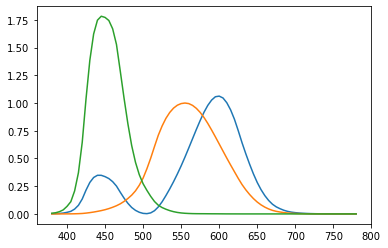

In [6]:
lam = np.arange(380., 781., 5)
cmf = np.loadtxt('../data/cie-cmf.txt', usecols=(1,2,3))
plt.plot(lam,cmf)

## Apply the model to GNP reflectance spectrum

In [7]:
#use the more regular grids of wavelength created in t01.ipynb
import pandas as pd
import pickle
#read data of wavelength, n, k, x1, xn, xd
[nv2, kv2, wv2, dv2, nkd]=pickle.load(open("../data/gold_nk.pkl", "rb" ))
nw=1.33+0j

df1=pickle.load(open("qv.pkl","rb"))
dt=40
ndz=1000

from rtfun import *
taum, Ref1,Tran1=tmm(df1,dt,ndz)

from scipy.interpolate import interp1d
#test the following
#fn = interp1d(wv2,Ref1)
#Ref1i=fn(lam)
#plt.plot(wv2,Ref1)
#plt.plot(lam, Ref1i,'.')

In [8]:
import PyMieScatt as ps
def run_mie(nv, kv, wv, dv):
    nd=len(dv)
    nwv=len(wv)
    
    #run the mie code for above parameters
    miev=np.array([[ps.MieQ(nv[i]+kv[i]*1.0j,wv[i],dv[j],asDict=True) \
                    for j in range(nd)] \
                   for i in range(nwv)])

    qextv=np.array([[miev[i,j]['Qext'] for j in range(nd)]for i in range(nwv)])
    qscav=np.array([[miev[i,j]['Qsca'] for j in range(nd)]for i in range(nwv)])
    qabsv=np.array([[miev[i,j]['Qabs'] for j in range(nd)]for i in range(nwv)])
    qbackv=np.array([[miev[i,j]['Qback'] for j in range(nd)]for i in range(nwv)])
    gv=np.array([[miev[i,j]['g'] for j in range(nd)]for i in range(nwv)])

    return [qextv,qscav,qscav/qextv,qabsv, qbackv,gv]

In [9]:
dv=[20,40,60,80,100,150,200,300,400]
wv=wv2
nv=nv2/1.33
kv=kv2/1.33
print("Consider GNP in water!!!")
#nv=nv2
#kv=kv2

#nv=nv2
#kv=kv2
datav1=run_mie(nv, kv, wv, dv)
datav1=np.array(datav1)

Consider GNP in water!!!


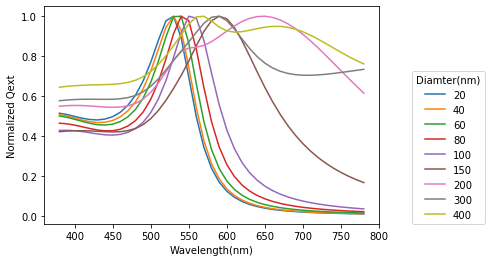

In [10]:
datat=datav1
fig, ax = plt.subplots()
#ax.set_yscale('log')
for i in range(len(dv)):
    df1=pd.DataFrame(np.array(datat)[:,:,i].T,\
                 columns=["Qext","Qsca","SSA","Qabs","Qback","Asymmetry factor"])
    fn = interp1d(wv2,df1['Qext'])
    qi=fn(lam)
    
    plt.plot(lam, qi/qi.max(),label=dv[i])
plt.xlabel("Wavelength(nm)")
plt.ylabel("Normalized Qext")
plt.legend(loc=(1.1,0),title="Diamter(nm)")
plt.savefig("../img/t11_qext.png",dpi=300)

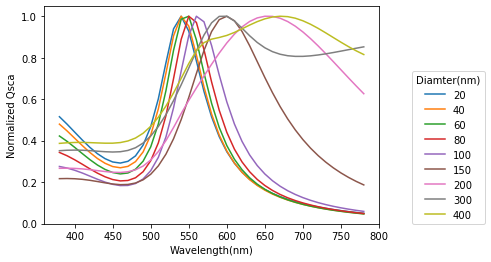

In [20]:
datat=datav1
fig, ax = plt.subplots()
#ax.set_yscale('log')
for i in range(len(dv)):
    df1=pd.DataFrame(np.array(datat)[:,:,i].T,\
                 columns=["Qext","Qsca","SSA","Qabs","Qback","Asymmetry factor"])
    fn = interp1d(wv2,df1['Qsca'])
    qi=fn(lam)
    
    plt.plot(lam, qi/qi.max(),label=dv[i])
plt.xlabel("Wavelength(nm)")
plt.ylabel("Normalized Qsca")
plt.legend(loc=(1.1,0),title="Diamter(nm)")
plt.savefig("../img/t11_qsca.png",dpi=300)

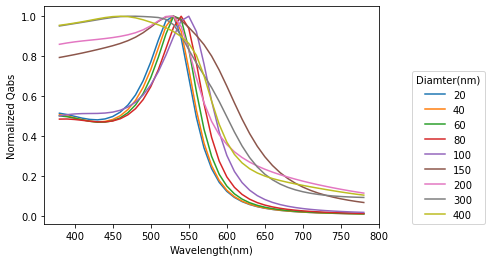

In [21]:
datat=datav1
fig, ax = plt.subplots()
#ax.set_yscale('log')
for i in range(len(dv)):
    df1=pd.DataFrame(np.array(datat)[:,:,i].T,\
                 columns=["Qext","Qsca","SSA","Qabs","Qback","Asymmetry factor"])
    fn = interp1d(wv2,df1['Qabs'])
    qi=fn(lam)
    
    plt.plot(lam, qi/qi.max(),label=dv[i])
plt.xlabel("Wavelength(nm)")
plt.ylabel("Normalized Qabs")
plt.legend(loc=(1.1,0),title="Diamter(nm)")
plt.savefig("../img/t11_qabs.png",dpi=300)

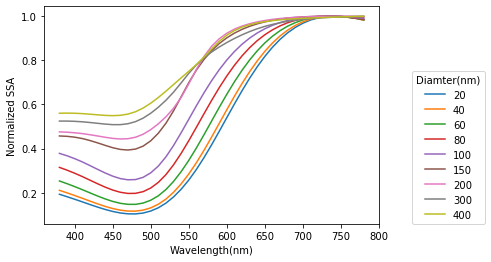

In [22]:
datat=datav1
fig, ax = plt.subplots()
#ax.set_yscale('log')
for i in range(len(dv)):
    df1=pd.DataFrame(np.array(datat)[:,:,i].T,\
                 columns=["Qext","Qsca","SSA","Qabs","Qback","Asymmetry factor"])
    fn = interp1d(wv2,df1['SSA'])
    qi=fn(lam)
    
    plt.plot(lam, qi/qi.max(),label=dv[i])
plt.xlabel("Wavelength(nm)")
plt.ylabel("Normalized SSA")
plt.legend(loc=(1.1,0),title="Diamter(nm)")
plt.savefig("../img/t11_ssa.png",dpi=300)

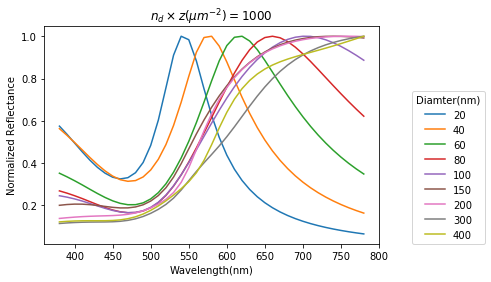

In [23]:
ndz=1000
datat=datav1

fig, ax = plt.subplots()
#ax.set_yscale('log')
for i in range(len(dv)):
    df1=pd.DataFrame(np.array(datat)[:,:,i].T,\
                 columns=["Qext","Qsca","SSA","Qabs","Qback","Asymmetry factor"])
    taum, Ref1,Tran1=tmm(df1,dv[i],ndz)
    fn = interp1d(wv2,Ref1)
    qi=fn(lam)
    
    plt.plot(lam, qi/qi.max(),label=dv[i])
plt.xlabel("Wavelength(nm)")
plt.ylabel("Normalized Reflectance")
plt.legend(loc=(1.1,0),title="Diamter(nm)")
plt.title(r"$n_d\times z (\mu m^{-2})=$"+str(ndz))
plt.savefig("../img/t11_ref_ndz"+str(ndz)+".png",dpi=300)

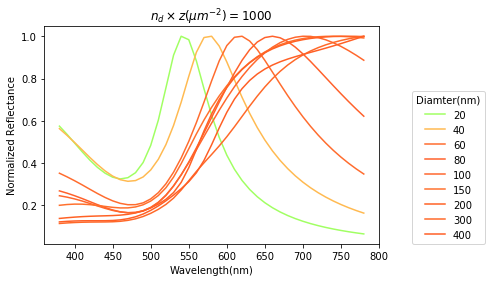

In [24]:
ndz=1000
datat=datav1

fig, ax = plt.subplots()
#ax.set_yscale('log')
for i in range(len(dv)):
    df1=pd.DataFrame(np.array(datat)[:,:,i].T,\
                 columns=["Qext","Qsca","SSA","Qabs","Qback","Asymmetry factor"])
    taum, Ref1,Tran1=tmm(df1,dv[i],ndz)
    fn = interp1d(wv2,Ref1)
    Ref1i=fn(lam)
    spec = Ref1i
    html_rgb = cs.spec_to_rgb(spec, out_fmt='html')
    
    plt.plot(lam, Ref1i/Ref1i.max(),label=dv[i],color=html_rgb)
plt.xlabel("Wavelength(nm)")
plt.ylabel("Normalized Reflectance")
plt.legend(loc=(1.1,0),title="Diamter(nm)")
plt.title(r"$n_d\times z (\mu m^{-2})=$"+str(ndz))
plt.savefig("../img/t11_ref2_ndz"+str(ndz)+".png",dpi=300)

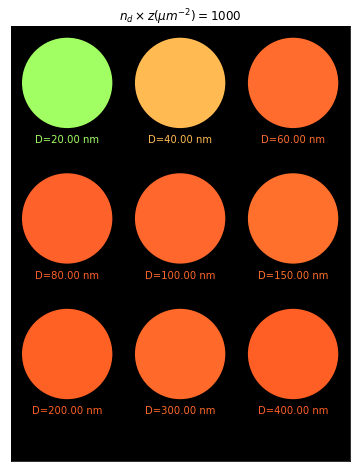

In [26]:
ndz=1000

import numpy as np
from scipy.constants import h, c, k
import matplotlib.pyplot as plt
from matplotlib.patches import Circle


fig, ax = plt.subplots(figsize=(8,8))
for i in range(len(dv)):
    # Calculate the black body spectrum and the HTML hex RGB colour string
    # it looks like
    
    df1=pd.DataFrame(np.array(datat)[:,:,i].T,\
                 columns=["Qext","Qsca","SSA","Qabs","Qback","Asymmetry factor"])
    taum, Ref1,Tran1=tmm(df1,dv[i],ndz)
    fn = interp1d(wv2,Ref1)
    Ref1i=fn(lam)
    
    spec = Ref1i
    html_rgb = cs.spec_to_rgb(spec, out_fmt='html')

    # Place and label a circle with the colour of a black body at temperature T
    x, y = i % 3, -(i // 3)
    circle = Circle(xy=(x, y*1.2), radius=0.4, fc=html_rgb)
    ax.add_patch(circle)
    ax.annotate('D=%3.2f nm' %(dv[i]), xy=(x, y*1.2-0.5), va='center',
                ha='center', color=html_rgb)

# Set the limits and background colour; remove the ticks
ax.set_xlim(-0.5,2.5)
ax.set_ylim(-3.35, 0.5)
ax.set_xticks([])
ax.set_yticks([])
ax.set_facecolor('k')
# Make sure our circles are circular!
ax.set_aspect("equal")
plt.title(r"$n_d\times z (\mu m^{-2})=$"+str(ndz))
plt.savefig("../img/t11_color_ndz"+str(ndz)+".png",dpi=300)
plt.show()

## backup example on Blackbody radiation

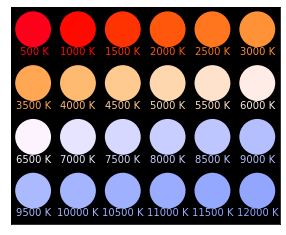

In [188]:
#code from https://scipython.com/blog/converting-a-spectrum-to-a-colour/
    
import numpy as np
from scipy.constants import h, c, k
import matplotlib.pyplot as plt
from matplotlib.patches import Circle

#from colour_system import cs_hdtv
cs = cs_hdtv

def planck(lam, T):
    """ Returns the spectral radiance of a black body at temperature T.

    Returns the spectral radiance, B(lam, T), in W.sr-1.m-2 of a black body
    at temperature T (in K) at a wavelength lam (in nm), using Planck's law.

    """

    lam_m = lam / 1.e9
    fac = h*c/lam_m/k/T
    B = 2*h*c**2/lam_m**5 / (np.exp(fac) - 1)
    return B

fig, ax = plt.subplots()

# The grid of visible wavelengths corresponding to the grid of colour-matching
# functions used by the ColourSystem instance.
lam = np.arange(380., 781., 5)

for i in range(24):
    # T = 500 to 12000 K
    T = 500*i + 500

    # Calculate the black body spectrum and the HTML hex RGB colour string
    # it looks like
    spec = planck(lam, T)
    html_rgb = cs.spec_to_rgb(spec, out_fmt='html')

    # Place and label a circle with the colour of a black body at temperature T
    x, y = i % 6, -(i // 6)
    circle = Circle(xy=(x, y*1.2), radius=0.4, fc=html_rgb)
    ax.add_patch(circle)
    ax.annotate('{:4d} K'.format(T), xy=(x, y*1.2-0.5), va='center',
                ha='center', color=html_rgb)

# Set the limits and background colour; remove the ticks
ax.set_xlim(-0.5,5.5)
ax.set_ylim(-4.35, 0.5)
ax.set_xticks([])
ax.set_yticks([])
ax.set_facecolor('k')
# Make sure our circles are circular!
ax.set_aspect("equal")
plt.show()